<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/voice_activity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a voice activity detection pipeline from scratch with `pyannote.audio`

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.  
In this tutorial, you will learn how to train and evaluate a VAD pipeline from scratch.

## Tutorial setup

### `Google Colab` setup

If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio` and download a mini version of the `AMI` corpus.

In [1]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!git clone https://github.com/pyannote/AMI-diarization-setup.git
%cd ./AMI-diarization-setup/pyannote/
!sh ./download_ami.sh
%cd /content

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.7/208.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

Then, restart the kernel (runtime -> restart session) to finalize the installation

### Non `Google Colab` setup

If you are not using `Colab`, this tutorial assumes that
* `pyannote.audio` has been installed
* the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)

## Data preparation

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [ ]:
from pyannote.database import registry, FileFinder

registry.load_database("AMI-diarization-setup/pyannote/database.yml")
preprocessors = {"audio": FileFinder()}
ami = registry.get_protocol('AMI.SpeakerDiarization.mini',
                   preprocessors=preprocessors)

`pyannote.database` *protocols* usually define
* a training set: `for training_file in protocol.train(): ...`,
* a validation set: `for validation_file in protocol.development(): ...`
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's listen to one minute of the first training file...

In [2]:
first_training_file = next(ami.train())
reference = first_training_file["annotation"]

In [3]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment

one_minute = Segment(240, 300)
listen(first_training_file, one_minute)

Output hidden; open in https://colab.research.google.com to view.

... and visualize the manual annotation:

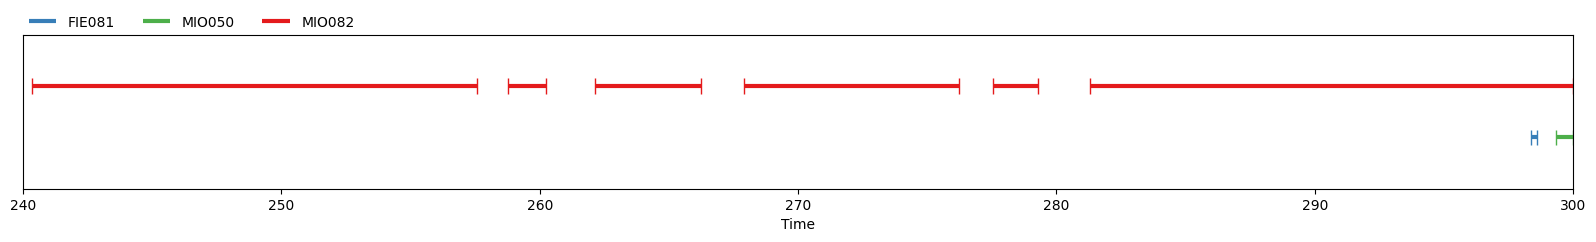

In [4]:
from pyannote.core import notebook
notebook.crop = one_minute
reference

## Training

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [5]:
from pyannote.audio.tasks import VoiceActivityDetection

vad = VoiceActivityDetection(ami, duration=2., batch_size=128)

Protocol AMI.SpeakerDiarization.mini does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad`) for which it is being trained:

In [6]:
from pyannote.audio.models.segmentation import PyanNet
import torch

model = PyanNet(sincnet={'stride': 10}, task=vad)

Now that everything is ready, let's train with `pytorch-ligthning`!

In [7]:
import pytorch_lightning as pl

# check whether cuda device (GPU) is available
if torch.cuda.is_available():
    # if yes, move model on it
    model.to(torch.device('cuda'))
    accelerator = "gpu"
else:
    accelerator = "cpu"

trainer = pl.Trainer(devices=1, max_epochs=1, accelerator=accelerator)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 589 K  | [1, 115, 60]  | [[1, 115, 256], [[4, 1, 128], [4, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


For the purpose of this tutorial, the model is trained for only 2 epochs. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, the model can be applied to a test file:

In [8]:
test_file = next(ami.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [9]:
from pyannote.audio import Inference
inference = Inference(model)
vad_probability = inference(test_file)

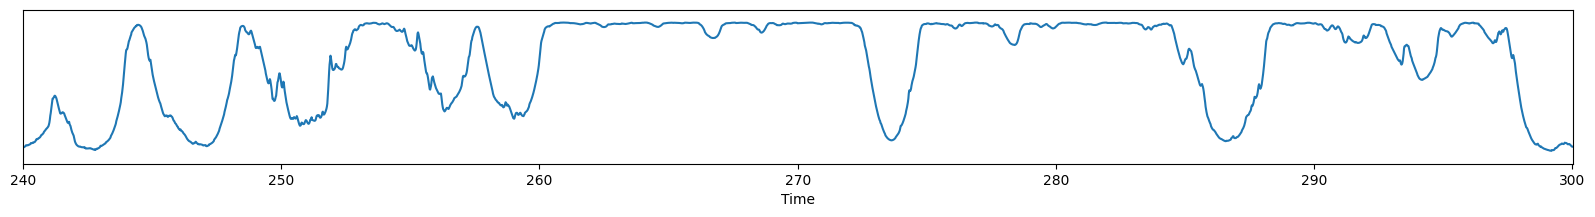

In [10]:
vad_probability

Perfect voice activity detection output should look like that:

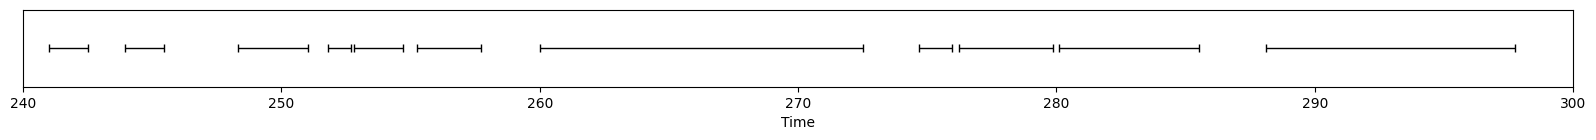

In [11]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [12]:
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.4,
                  "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)

Here we go:

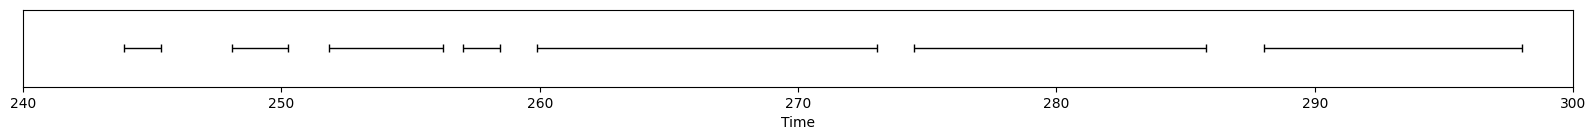

In [13]:
pipeline(test_file).get_timeline()

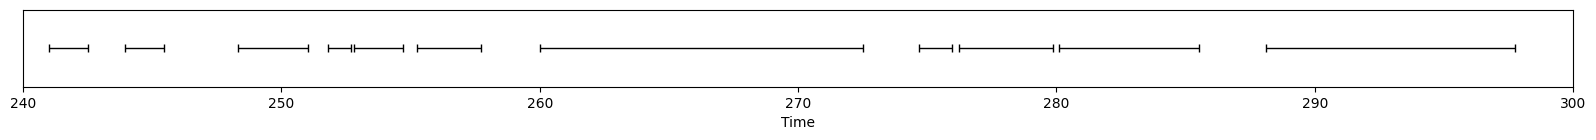

In [14]:
expected_output

Looks decent! Let's perform a proper evaluation by computing the [detection error rate](https://pyannote.github.io/pyannote-metrics/reference.html#detection) over the whole AMI test set:

In [15]:
from pyannote.metrics.detection import DetectionErrorRate
metric = DetectionErrorRate()

for file in ami.test():

    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated

# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 12.4%


## Optimizing pipeline hyper-parameters

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [16]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [17]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()),
               warm_start=initial_params,
               n_iterations=20,
               show_progress=False)

optimized_params = optimizer.best_params

There you go: better hyper-parameters that (should) lead to better results!

In [18]:
print(optimized_params)

{'onset': 0.824238792126195, 'offset': 0.5375254799320842, 'min_duration_on': 0.0, 'min_duration_off': 0.0}


Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [19]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in ami.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 12.0%


🎉 Yeay! We can see an improvement simply by adjusting the thresholds.